In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
cambio = pd.read_excel('../datasets/tc_turistas.xlsx',
                       sheet_name=0)

turista = pd.read_excel('../datasets/tc_turistas.xlsx',
                        sheet_name=2)

In [ ]:
cambio = pd.read_excel("tc_turistas.xlsx", sheet_name="tipos de cambio")
turista = pd.read_excel("tc_turistas.xlsx", 
                            sheet_name="llegadas de turistas")

In [ ]:
cambio.head(5)

,FECHA,DOLAR Oficial,DOLAR Blue
0,2017-06-01,16.25,16.30
1,2017-06-02,16.20,16.32
2,2017-06-03,NaN,NaN
3,2017-06-04,NaN,NaN
4,2017-06-05,16.20,16.34


In [ ]:
turista.head(5)

,anio,mes,date,Bolivia,Brasil,Chile,Paraguay,Uruguay
0,2013,ene,41275,141417.459190,112996.623524,66007.699999,50277.720853,52456.413939
1,2013,feb,41306,95204.256341,161366.098439,62013.313451,52666.951095,41377.875955
2,2013,mar,41334,82862.061107,96727.365114,81096.057038,92714.958474,43728.713276
3,2013,abr,41365,72009.462620,66978.888460,55096.585327,67716.242304,27458.646062
4,2013,may,41395,79131.435938,63886.966089,61641.446807,70544.694702,23592.398421


## Limpieza de datos

### Cambio

In [ ]:
cambio.rename(
    columns={
        'FECHA': 'fecha',
        'DOLAR Oficial': 'dolar_oficial',
        'DOLAR Blue': 'dolar_blue'
    },
    inplace=True
)

Para completar los múltiples datos faltantes de los precios decidimos usar el último valor observado.

Otra forma posible hubise sido usar alguna medida resumen para los valores faltantes, pero en este caso eso haría que fluctúe mucho el incremento del dólar, cuando en realidad tiene una tendencia creciente.

In [ ]:
cambio.dolar_oficial.fillna(method='ffill', inplace=True)
cambio.dolar_blue.fillna(method='ffill', inplace=True)

Agrupamos por mes y calculamos el promedio de los valores.

In [ ]:
cambio_mensual = cambio.set_index('fecha').resample('M').mean()

In [ ]:
cambio_mensual.index = cambio_mensual.index.strftime('%Y-%m')

In [ ]:
cambio_mensual.iloc[:, 0:2] = \
    cambio_mensual.iloc[:, 0:2].round(2)

### Turista

In [ ]:
turista.rename(
    columns={col: col.lower() for col in turista.columns},
    inplace=True
)

Casteamos las columnas de los turistas llegados de cada país a `int`.

In [ ]:
turista[turista.columns[3:]] =\
    turista[turista.columns[3:]].round().astype('int64')

Viendo los máximos de cada campo vemos que hay un valor atípico en uno de ellos.

In [ ]:
turista.max()

anio                   2021
mes                     sep
date                  44256
bolivia              187955
brasil               242583
chile       571838802363218
paraguay             138973
uruguay               86375
dtype: object

El valor atípico lo tiene la entrada de año 2018 y mes abril.

In [ ]:
turista[turista.chile == 571838802363218]

,anio,mes,date,bolivia,brasil,chile,paraguay,uruguay
63,2018,abr,43191,87508,77917,571838802363218,57205,34822


Decidimos tomar el promedio del año previo y sucesor de 2018 para reemplazar el valor atípico.

In [ ]:
turista.loc[turista.chile == 571838802363218, 'chile'] = \
    turista[(turista.anio.isin([2017, 2019])) & (turista.mes == 'abr')]\
        .chile.mean()\
        .astype('int64')

Pasamos la columna `date` a formato `datetime`.

In [ ]:
turista.date = \
    pd.to_datetime(turista.date, unit='d', origin='1899-12-30')  

In [ ]:
turista['fecha_mensual'] = \
    turista.date.dt.strftime('%Y-%m')

In [ ]:
turista_cambio = \
    pd.merge(cambio_mensual, turista, 
            left_index=True, right_on='fecha_mensual', 
            how='left')

In [ ]:
turista_cambio = \
    turista_cambio\
        .drop(columns=['anio', 'mes', 'date'])\
        .reindex(columns=['fecha_mensual', 'dolar_oficial',
                        'dolar_blue', 'bolivia', 'brasil',
                        'chile', 'paraguay', 'uruguay'])

In [ ]:
turista_cambio.set_index('fecha_mensual')

,dolar_oficial,dolar_blue,bolivia,brasil,chile,paraguay,uruguay
fecha_mensual,,,,,,,
2017-06,16.29,16.50,91354,44950,51902,44106,22150
2017-07,17.38,17.17,139655,67292,90151,74440,25873
2017-08,17.63,18.22,101980,53708,67773,60127,26348
2017-09,17.43,17.95,113370,79189,66417,70245,20975
2017-10,17.66,17.96,108989,86279,74251,65150,27706
2017-11,17.69,18.05,100107,73925,67212,58810,41117
2017-12,17.95,18.31,113631,106259,162180,54932,53165
2018-01,19.27,19.65,156813,124144,98232,47639,72067
2018-02,20.09,20.16,96557,170947,80981,49857,56729


### Dataframe final

In [ ]:
turista_cambio

,fecha_mensual,dolar_oficial,dolar_blue,bolivia,brasil,chile,paraguay,uruguay
53,2017-06,16.29,16.50,91354,44950,51902,44106,22150
54,2017-07,17.38,17.17,139655,67292,90151,74440,25873
55,2017-08,17.63,18.22,101980,53708,67773,60127,26348
56,2017-09,17.43,17.95,113370,79189,66417,70245,20975
57,2017-10,17.66,17.96,108989,86279,74251,65150,27706
58,2017-11,17.69,18.05,100107,73925,67212,58810,41117
59,2017-12,17.95,18.31,113631,106259,162180,54932,53165
60,2018-01,19.27,19.65,156813,124144,98232,47639,72067
61,2018-02,20.09,20.16,96557,170947,80981,49857,56729
62,2018-03,20.48,20.74,77100,87156,83496,66549,54561


In [ ]:
turista_cambio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 53 to 85
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fecha_mensual  33 non-null     object 
 1   dolar_oficial  33 non-null     float64
 2   dolar_blue     33 non-null     float64
 3   bolivia        33 non-null     int64  
 4   brasil         33 non-null     int64  
 5   chile          33 non-null     int64  
 6   paraguay       33 non-null     int64  
 7   uruguay        33 non-null     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 2.3+ KB


## Exportación a formato parquet


In [ ]:
tabla = pa.Table.from_pandas(turista_cambio)
pq.write_table(tabla, 'turista_cambio.parquet')
#agregale luego la dir donde lo guarda

## Exploración de datos

In [ ]:
datos =  \
    {'valores':['minimo', 'maximo', 'rango'],
     'dolar_oficial':\
       [turista_cambio.dolar_oficial.min(),
        turista_cambio.dolar_oficial.max(),
        turista_cambio.dolar_oficial.max() - turista_cambio.dolar_oficial.min()],
     'dolar_blue': \
        [turista_cambio.dolar_blue.min(),
         turista_cambio.dolar_blue.max(),
         turista_cambio.dolar_blue.max() - turista_cambio.dolar_blue.min()],
          }

tabla_cambio = pd.DataFrame(datos)
tabla_cambio

,valores,dolar_oficial,dolar_blue
0,minimo,16.29,16.50
1,maximo,63.31,78.21
2,rango,47.02,61.71


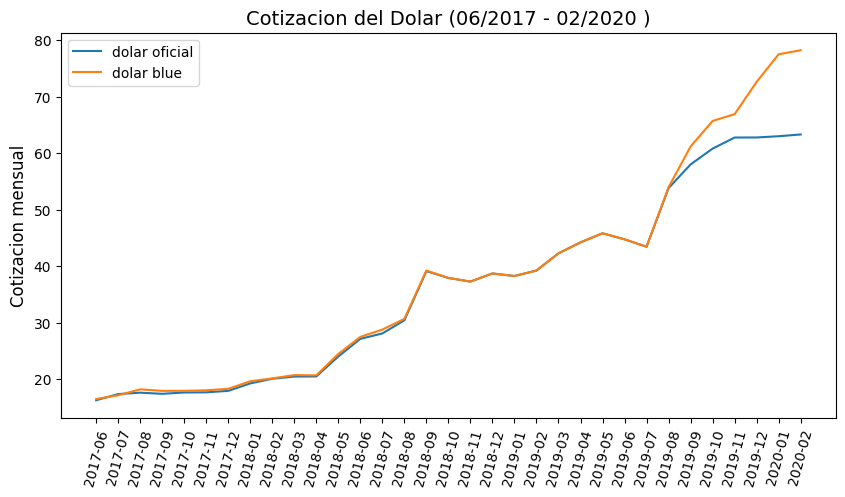

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(turista_cambio.fecha_mensual,
         turista_cambio.dolar_oficial, label = 'dolar oficial')
plt.plot(turista_cambio.fecha_mensual, 
         turista_cambio.dolar_blue, label = 'dolar blue')
#rota las etiquetas del eje x y tamaño de la fuente 
plt.xticks(rotation = 75,fontsize=10);
plt.yticks(fontsize=10)
plt.ylabel('Cotizacion mensual', fontsize=12)
plt.title('Cotizacion del Dolar (06/2017 - 02/2020 )',  fontsize=14)
plt.legend()
plt.savefig('grafico_cambio.png', bbox_inches = 'tight')


<Axes: >

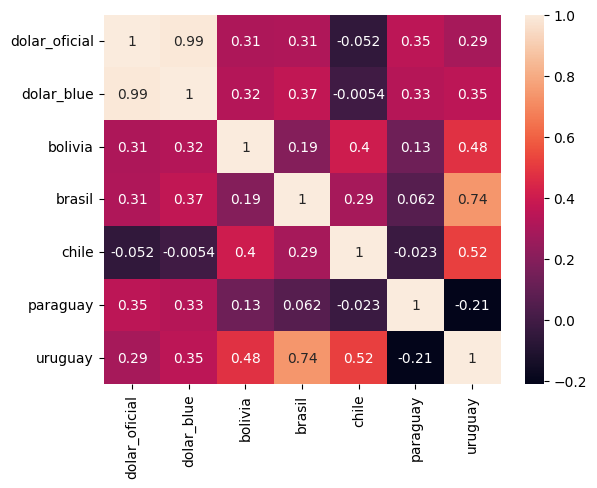

In [ ]:
sns.heatmap(turista_cambio[['dolar_oficial', 'dolar_blue', 'bolivia','brasil','chile','paraguay','uruguay']].corr(),annot=True)

In [ ]:
datos_pais = {
     'Paises':['Bolivia', 'Brasil', 'Chile', 'Paraguay','Uruguay'],
     'Cantidad_turistas':[turista_cambio.bolivia.sum(),
                          turista_cambio.brasil.sum(),
                          turista_cambio.chile.sum(),
                          turista_cambio.paraguay.sum(),
                          turista_cambio.uruguay.sum()]}
             
total_pais = pd.DataFrame(datos_pais)                
total_pais['Porcentaje'] = ((total_pais['Cantidad_turistas']/
                            total_pais['Cantidad_turistas'].sum())*100).round(2)
total_pais                            

,Paises,Cantidad_turistas,Porcentaje
0,Bolivia,3856800,29.87
1,Brasil,3079001,23.85
2,Chile,2505529,19.41
3,Paraguay,2078060,16.09
4,Uruguay,1392370,10.78


In [ ]:
def graficar_barras(titulo, titulo_x, titulo_y, savefig_name, etiquetas_x, datos_y, angulo, tamaño):
    
    plt.figure(figsize = tamaño)          
    plt.xticks(rotation = angulo,fontsize=10); 
    plt.yticks(fontsize=10);               
    plt.xlabel(titulo_x,fontsize=12) 
    plt.ylabel(titulo_y,fontsize=12)                              
    plt.title(titulo,fontsize=14)                    
    plt.bar(etiquetas_x,datos_y)
    plt.savefig(savefig_name, bbox_inches = 'tight')


In [ ]:
#este ultimo grafico no se si es el mejor para ver enaanios completos los meses 
#que mas turistas hay y los menos
turista_cambio['fecha_mensual'] = pd.to_datetime(turista['fecha_mensual'])

datos_2018 = turista_cambio[turista_cambio['fecha_mensual'].dt.year == 2018]
datos_2019 = turista_cambio[turista_cambio['fecha_mensual'].dt.year == 2019]

etiquetas = ['enero', 'febrero','marzo', 'abril', 'mayo', 'junio', 'julio',
               'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']

datos_1 = datos_2018['bolivia'] + datos_2018['brasil'] + datos_2018['chile']+ \
          datos_2018['paraguay'] + datos_2018['uruguay'] 

datos_2 = datos_2019['bolivia'] + datos_2019['brasil'] + datos_2019['chile']+ \
          datos_2019['paraguay'] + datos_2019['uruguay']         


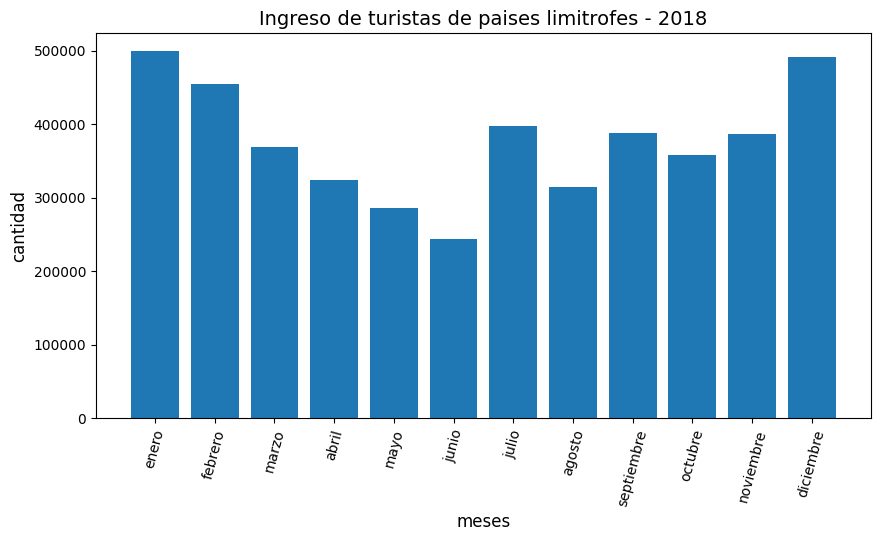

In [ ]:
graficar_barras("Ingreso de turistas de paises limitrofes - 2018","meses",
          "cantidad",'grafico_tuista_2018.png',etiquetas, datos_1,angulo = 75, 
           tamaño = (10,5))

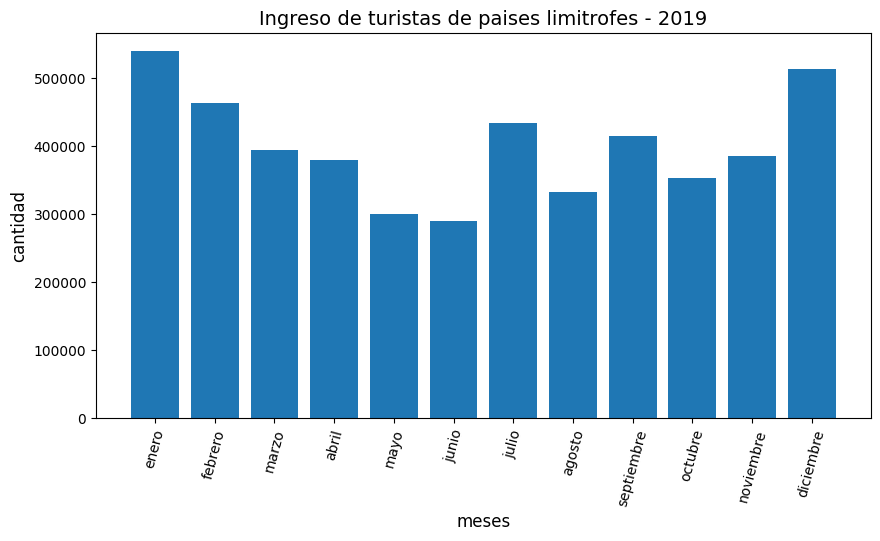

In [ ]:
graficar_barras("Ingreso de turistas de paises limitrofes - 2019","meses",
          "cantidad",'grafico_tuista_2019.png',etiquetas, datos_2,angulo = 75, 
           tamaño = (10,5))

# Conclusiones